## Get the Data

Either use the provided .csv file or (optionally) get fresh (the freshest?) data from running an SQL query on StackExchange: 

Follow this link to run the query from [StackExchange](https://data.stackexchange.com/stackoverflow/query/675441/popular-programming-languages-per-over-time-eversql-com) to get your own .csv file

<code>
select dateadd(month, datediff(month, 0, q.CreationDate), 0) m, TagName, count(*)
from PostTags pt
join Posts q on q.Id=pt.PostId
join Tags t on t.Id=pt.TagId
where TagName in ('java','c','c++','python','c#','javascript','assembly','php','perl','ruby','visual basic','swift','r','object-c','scratch','go','swift','delphi')
and q.CreationDate < dateadd(month, datediff(month, 0, getdate()), 0)
group by dateadd(month, datediff(month, 0, q.CreationDate), 0), TagName
order by dateadd(month, datediff(month, 0, q.CreationDate), 0)
</code>

## Import Statements

In [19]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Make plots look a bit nicer by default
sns.set(style="darkgrid")

## Data Exploration

**Challenge**: Read the .csv file and store it in a Pandas dataframe

In [20]:
# Read the CSV file into a DataFrame
csv_path = Path('QueryResults.csv')
df = pd.read_csv(csv_path)
# Rename unnamed third column (if present) to 'count' for clarity
df = df.rename(columns={c: 'count' if 'Unnamed' in c or c.strip()=='' else c for c in df.columns})
# Quick preview of columns
df.columns = [c.strip() for c in df.columns]
df.head()

,m,TagName,count
0,2008-07-01 00:00:00,c#,3
1,2008-08-01 00:00:00,assembly,8
2,2008-08-01 00:00:00,javascript,162
3,2008-08-01 00:00:00,c,85
4,2008-08-01 00:00:00,python,124


**Challenge**: Examine the first 5 rows and the last 5 rows of the of the dataframe

In [21]:
# Show first 5 and last 5 rows
display(df.head())
display(df.tail())

,m,TagName,count
0,2008-07-01 00:00:00,c#,3
1,2008-08-01 00:00:00,assembly,8
2,2008-08-01 00:00:00,javascript,162
3,2008-08-01 00:00:00,c,85
4,2008-08-01 00:00:00,python,124


,m,TagName,count
1986,2020-07-01 00:00:00,r,5694
1987,2020-07-01 00:00:00,go,743
1988,2020-07-01 00:00:00,ruby,775
1989,2020-07-01 00:00:00,perl,182
1990,2020-07-01 00:00:00,swift,3607


**Challenge:** Check how many rows and how many columns there are. 
What are the dimensions of the dataframe?

In [22]:
# Dimensions of the DataFrame
df.shape

(1991, 3)

**Challenge**: Count the number of entries in each column of the dataframe

In [23]:
# Count non-null entries per column
df.count()

m          1991
TagName    1991
count      1991
dtype: int64

**Challenge**: Calculate the total number of post per language.
Which Programming language has had the highest total number of posts of all time?

In [24]:
# Total number of posts per programming language (all time)
# Ensure the count column is numeric
df['count'] = pd.to_numeric(df['count'], errors='coerce')
total_per_lang = df.groupby('TagName')['count'].sum().sort_values(ascending=False)
total_per_lang

TagName
javascript    2056510
java          1696403
python        1496210
c#            1423530
php           1361988
c++            684210
r              356799
c              336042
swift          273055
ruby           214582
perl            65286
go              47499
delphi          46212
assembly        34852
Name: count, dtype: int64

Some languages are older (e.g., C) and other languages are newer (e.g., Swift). The dataset starts in September 2008.

**Challenge**: How many months of data exist per language? Which language had the fewest months with an entry? 


In [25]:
# How many months of data exist per language
months_per_lang = df.groupby('TagName')['m'].nunique().sort_values()
months_per_lang

TagName
go            129
swift         135
r             142
assembly      144
java          144
delphi        144
c++           144
c             144
python        144
javascript    144
php           144
perl          144
ruby          144
c#            145
Name: m, dtype: int64

## Data Cleaning

Let's fix the date format to make it more readable. We need to use Pandas to change format from a string of "2008-07-01 00:00:00" to a datetime object with the format of "2008-07-01"

In [26]:
# Data cleaning: convert 'm' to datetime and normalize to month start
df['m'] = pd.to_datetime(df['m'], errors='coerce')
# Keep only the date (month precision)
df['m'] = df['m'].dt.to_period('M').dt.to_timestamp()
# Show types after conversion
df.dtypes

m          datetime64[ns]
TagName            object
count               int64
dtype: object

In [27]:
# Quick sanity check: any missing values?
df.isna().sum()

m          0
TagName    0
count      0
dtype: int64

In [28]:
# If there are any missing counts, drop or fill with 0 (shouldn't be many)
df['count'] = df['count'].fillna(0).astype(int)
df.head()

,m,TagName,count
0,2008-07-01,c#,3
1,2008-08-01,assembly,8
2,2008-08-01,javascript,162
3,2008-08-01,c,85
4,2008-08-01,python,124


## Data Manipulation



In [29]:
# Pivot the data so each programming language becomes a column and rows are months
pivot = df.pivot_table(index='m', columns='TagName', values='count', aggfunc='sum').sort_index()
# Replace NaN with 0 for plotting and analysis
pivot = pivot.fillna(0)
pivot.index = pd.to_datetime(pivot.index)  # ensure datetime index for plotting
pivot.head()

TagName,assembly,c,c#,c++,delphi,go,java,javascript,perl,php,python,r,ruby,swift
m,,,,,,,,,,,,,,
2008-07-01,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-08-01,8.0,85.0,511.0,164.0,14.0,0.0,222.0,162.0,28.0,161.0,124.0,0.0,73.0,0.0
2008-09-01,28.0,321.0,1649.0,755.0,105.0,0.0,1137.0,640.0,131.0,482.0,542.0,6.0,290.0,0.0
2008-10-01,15.0,303.0,1989.0,811.0,112.0,0.0,1153.0,725.0,127.0,617.0,510.0,0.0,249.0,0.0
2008-11-01,17.0,259.0,1730.0,735.0,141.0,0.0,958.0,579.0,97.0,504.0,452.0,1.0,160.0,0.0


**Challenge**: What are the dimensions of our new dataframe? How many rows and columns does it have? Print out the column names and print out the first 5 rows of the dataframe.

In [30]:
# Dimensions, columns and first 5 rows of the pivoted dataframe
pivot.shape, list(pivot.columns)[:20], pivot.head()

((145, 14),
 ['assembly',
  'c',
  'c#',
  'c++',
  'delphi',
  'go',
  'java',
  'javascript',
  'perl',
  'php',
  'python',
  'r',
  'ruby',
  'swift'],
 TagName     assembly      c      c#    c++  delphi   go    java  javascript  \
 m                                                                             
 2008-07-01       0.0    0.0     3.0    0.0     0.0  0.0     0.0         0.0   
 2008-08-01       8.0   85.0   511.0  164.0    14.0  0.0   222.0       162.0   
 2008-09-01      28.0  321.0  1649.0  755.0   105.0  0.0  1137.0       640.0   
 2008-10-01      15.0  303.0  1989.0  811.0   112.0  0.0  1153.0       725.0   
 2008-11-01      17.0  259.0  1730.0  735.0   141.0  0.0   958.0       579.0   
 
 TagName      perl    php  python    r   ruby  swift  
 m                                                    
 2008-07-01    0.0    0.0     0.0  0.0    0.0    0.0  
 2008-08-01   28.0  161.0   124.0  0.0   73.0    0.0  
 2008-09-01  131.0  482.0   542.0  6.0  290.0    0.0  
 2008-1

In [31]:
# Count the number of monthly entries per programming language in the pivot (non-zero months)
nonzero_counts = (pivot > 0).sum().sort_values()
nonzero_counts

TagName
go            129
swift         135
r             142
assembly      144
java          144
delphi        144
c++           144
c             144
python        144
javascript    144
php           144
perl          144
ruby          144
c#            145
dtype: int64

In [32]:
# Alternative view: original TagName counts (why different?)
df['TagName'].value_counts().sort_values()

TagName
go            129
swift         135
r             142
assembly      144
c++           144
javascript    144
c             144
python        144
php           144
java          144
perl          144
delphi        144
ruby          144
c#            145
Name: count, dtype: int64

**Challenge**: Count the number of entries per programming language. Why might the number of entries be different? 

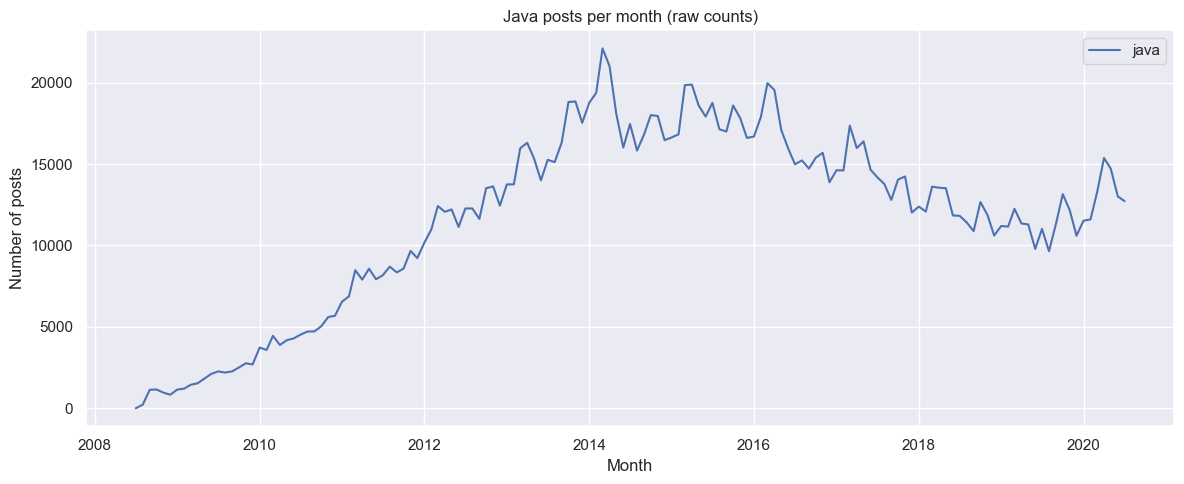

In [33]:
# Plot a single language (example: java)
plt.figure(figsize=(12,5))
if 'java' in pivot.columns:
    plt.plot(pivot.index, pivot['java'], label='java')
    plt.title('Java posts per month (raw counts)')
    plt.xlabel('Month')
    plt.ylabel('Number of posts')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('java not found in dataset')

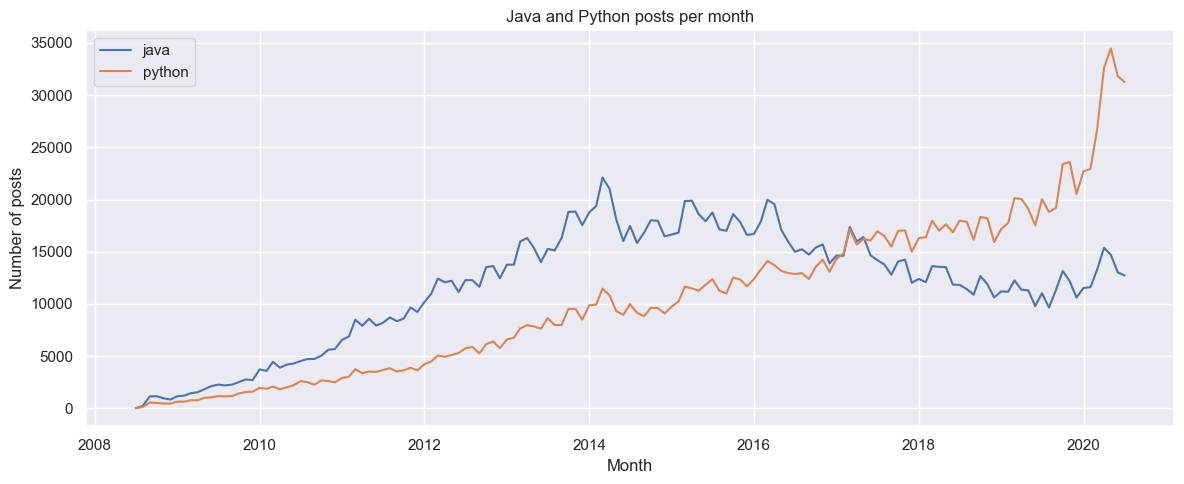

In [34]:
# Show two lines (Java and Python) on the same chart
plt.figure(figsize=(12,5))
for lang in ['java','python']:
    if lang in pivot.columns:
        plt.plot(pivot.index, pivot[lang], label=lang)
plt.title('Java and Python posts per month')
plt.xlabel('Month')
plt.ylabel('Number of posts')
plt.legend()
plt.tight_layout()
plt.show()

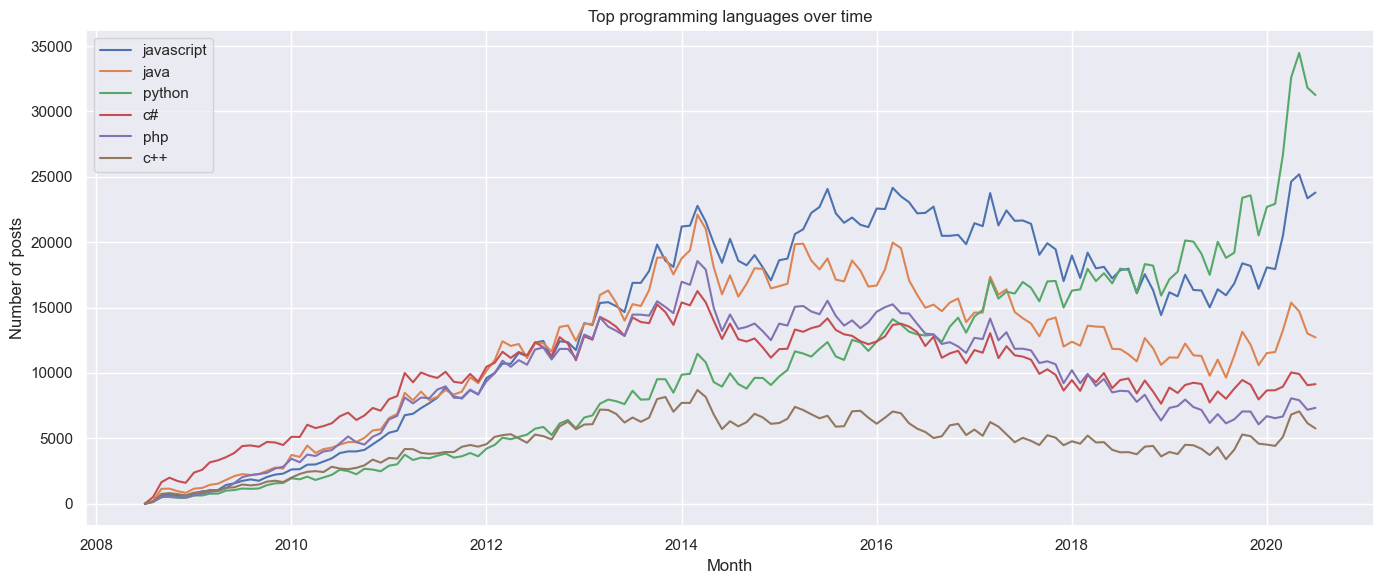

In [35]:
# Plot multiple languages together (top 6 by total posts)
top_langs = total_per_lang.head(6).index.tolist()
plt.figure(figsize=(14,6))
for lang in top_langs:
    if lang in pivot.columns:
        plt.plot(pivot.index, pivot[lang], label=lang)
plt.title('Top programming languages over time')
plt.xlabel('Month')
plt.ylabel('Number of posts')
plt.legend()
plt.tight_layout()
plt.show()

## Data Visualisaton with with Matplotlib


**Challenge**: Use the [matplotlib documentation](https://matplotlib.org/3.2.1/api/_as_gen/matplotlib.pyplot.plot.html#matplotlib.pyplot.plot) to plot a single programming language (e.g., java) on a chart.

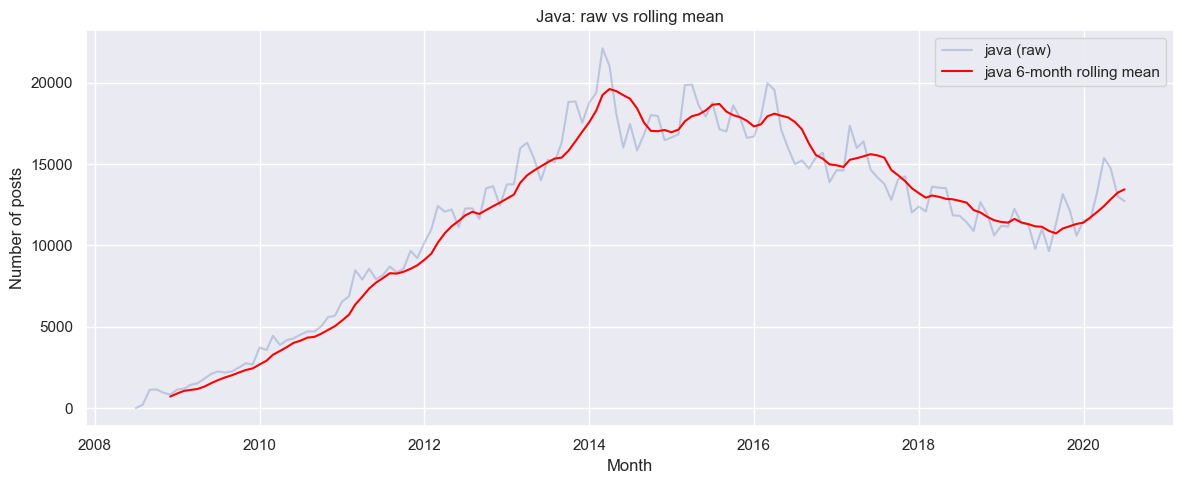

In [36]:
# Demonstrate smoothing with a 6-month rolling mean for Java
window = 6
if 'java' in pivot.columns:
    java_roll = pivot['java'].rolling(window=window).mean()
    plt.figure(figsize=(12,5))
    plt.plot(pivot.index, pivot['java'], alpha=0.3, label='java (raw)')
    plt.plot(java_roll.index, java_roll, color='red', label=f'java {window}-month rolling mean')
    plt.title('Java: raw vs rolling mean')
    plt.xlabel('Month')
    plt.ylabel('Number of posts')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('java not in data')

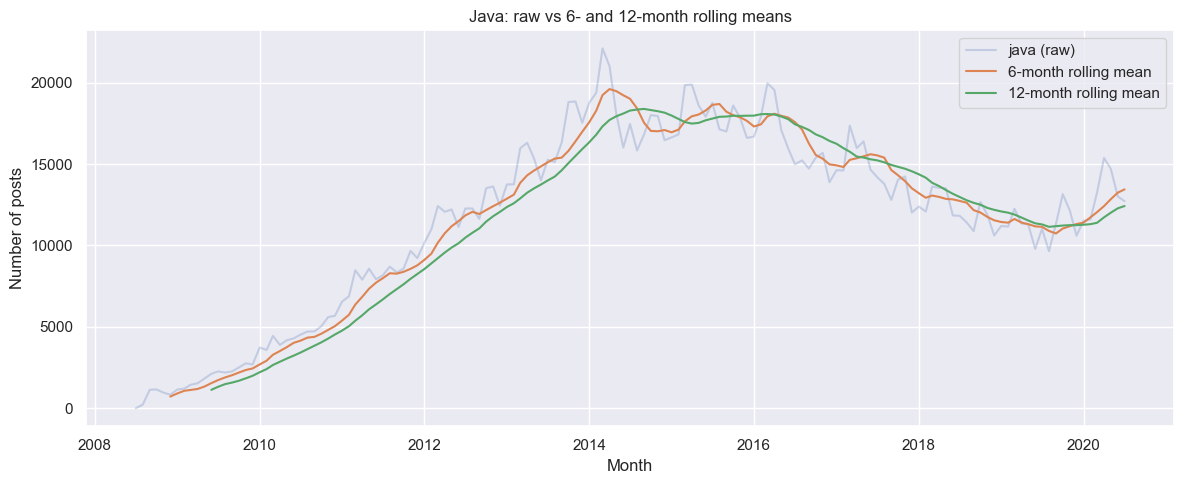

In [37]:
# Compare 6-month and 12-month rolling means for Java
if 'java' in pivot.columns:
    r6 = pivot['java'].rolling(window=6).mean()
    r12 = pivot['java'].rolling(window=12).mean()
    plt.figure(figsize=(12,5))
    plt.plot(pivot.index, pivot['java'], alpha=0.25, label='java (raw)')
    plt.plot(r6.index, r6, label='6-month rolling mean')
    plt.plot(r12.index, r12, label='12-month rolling mean')
    plt.title('Java: raw vs 6- and 12-month rolling means')
    plt.xlabel('Month')
    plt.ylabel('Number of posts')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('java not in pivot')

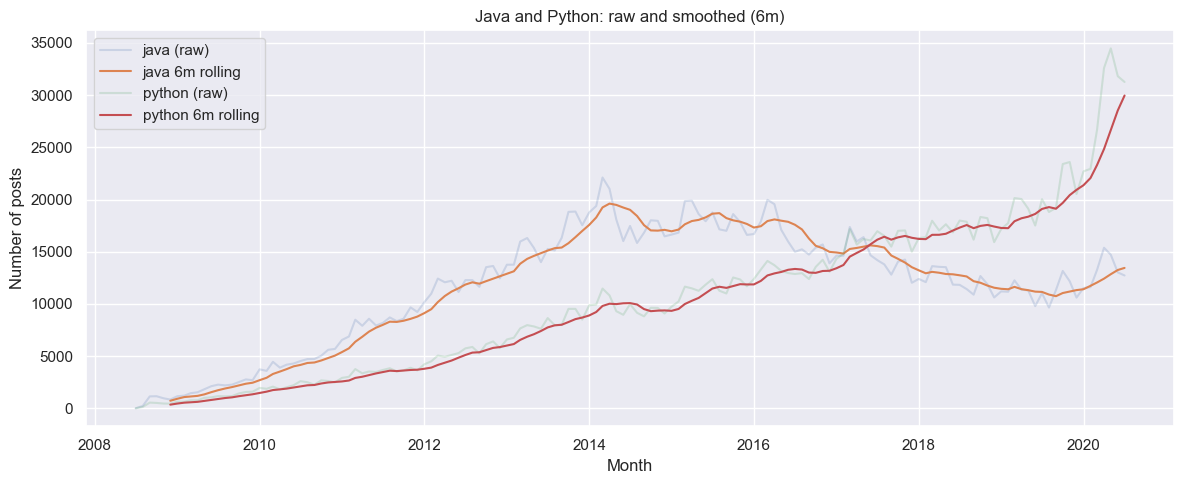

In [38]:
# Compute and plot 6-month rolling mean for Java and Python alongside raw
window = 6
plt.figure(figsize=(12,5))
for lang in ['java','python']:
    if lang in pivot.columns:
        raw = pivot[lang]
        roll = raw.rolling(window=window).mean()
        plt.plot(raw.index, raw, alpha=0.2, label=f'{lang} (raw)')
        plt.plot(roll.index, roll, label=f'{lang} {window}m rolling')
plt.title('Java and Python: raw and smoothed (6m)')
plt.xlabel('Month')
plt.ylabel('Number of posts')
plt.legend()
plt.tight_layout()
plt.show()

**Challenge**: Show two line (e.g. for Java and Python) on the same chart.

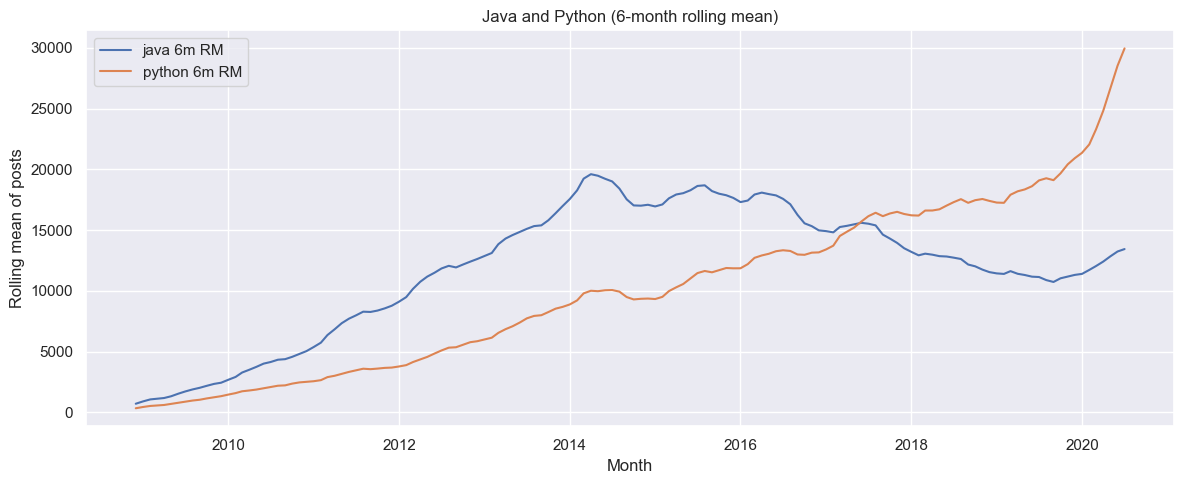

In [39]:
# Show two smoothed lines (Java and Python 6-month rolling)
window = 6
plt.figure(figsize=(12,5))
for lang in ['java','python']:
    if lang in pivot.columns:
        plt.plot(pivot.index, pivot[lang].rolling(window=window).mean(), label=f'{lang} {window}m RM')
plt.title('Java and Python (6-month rolling mean)')
plt.xlabel('Month')
plt.ylabel('Rolling mean of posts')
plt.legend()
plt.tight_layout()
plt.show()

# Smoothing out Time Series Data

Time series data can be quite noisy, with a lot of up and down spikes. To better see a trend we can plot an average of, say 6 or 12 observations. This is called the rolling mean. We calculate the average in a window of time and move it forward by one overservation. Pandas has two handy methods already built in to work this out: [rolling()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html) and [mean()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.core.window.rolling.Rolling.mean.html). 

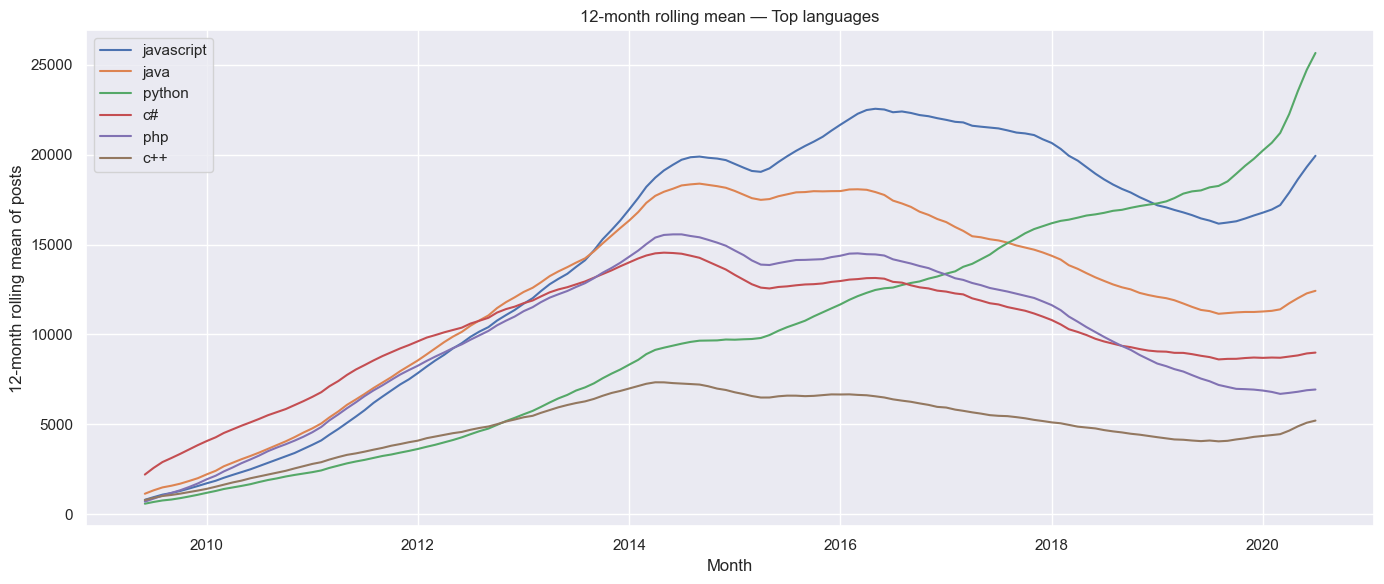

In [40]:
# 12-month rolling mean for top languages
top_langs = total_per_lang.head(6).index.tolist()
roll12 = pivot[top_langs].rolling(window=12).mean()
plt.figure(figsize=(14,6))
for col in roll12.columns:
    plt.plot(roll12.index, roll12[col], label=col)
plt.title('12-month rolling mean — Top languages')
plt.xlabel('Month')
plt.ylabel('12-month rolling mean of posts')
plt.legend()
plt.tight_layout()
plt.show()

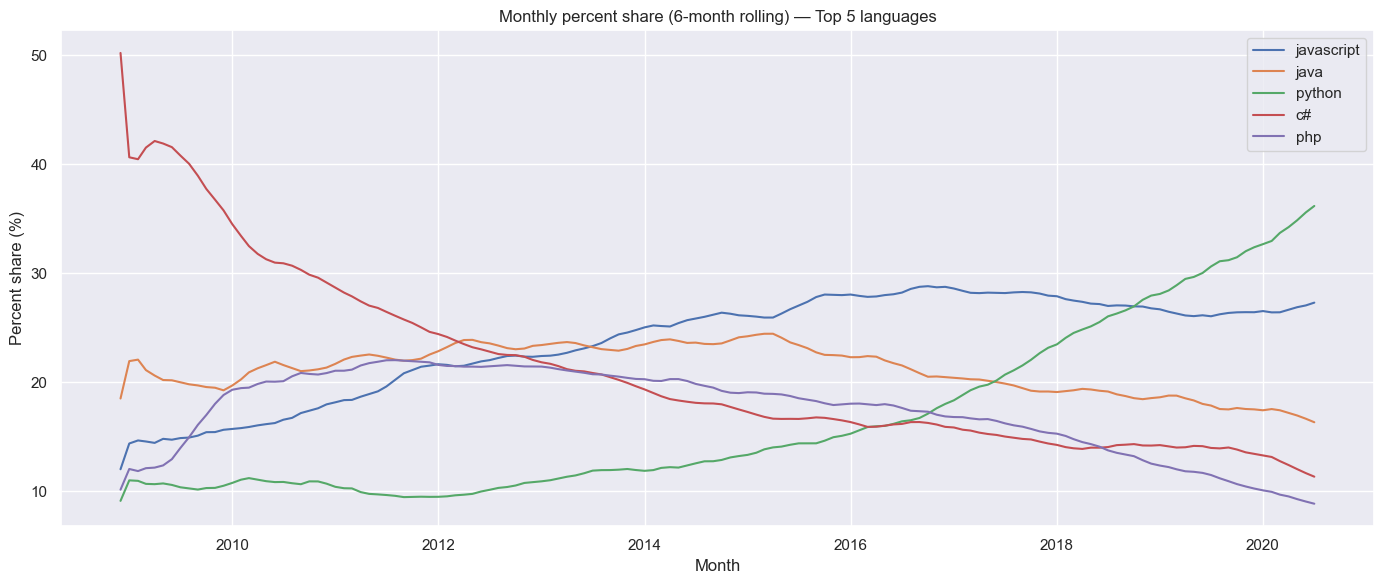

In [41]:
# Percentage share (monthly) for top 5 languages and 6-month rolling mean
top5 = total_per_lang.head(5).index.tolist()
monthly_share = pivot[top5].div(pivot[top5].sum(axis=1), axis=0) * 100
monthly_share_rm = monthly_share.rolling(window=6).mean()
plt.figure(figsize=(14,6))
for col in monthly_share_rm.columns:
    plt.plot(monthly_share_rm.index, monthly_share_rm[col], label=col)
plt.title('Monthly percent share (6-month rolling) — Top 5 languages')
plt.xlabel('Month')
plt.ylabel('Percent share (%)')
plt.legend()
plt.tight_layout()
plt.show()

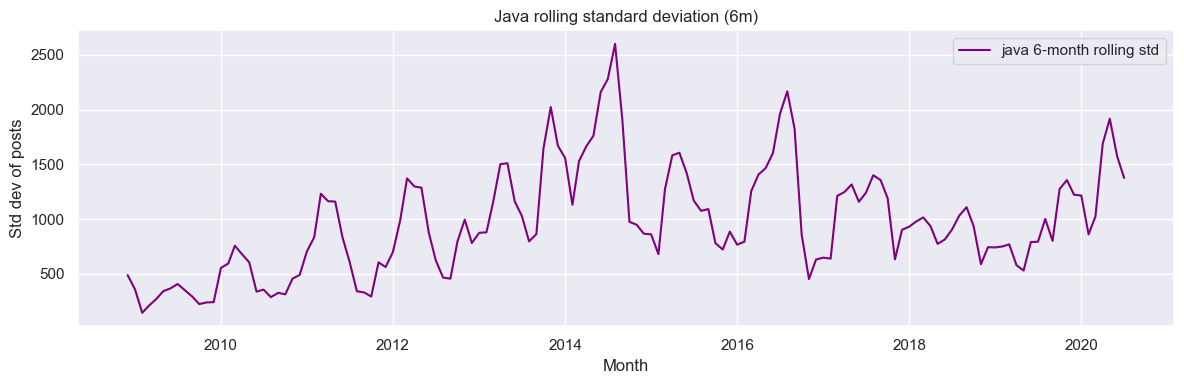

In [42]:
# Rolling standard deviation (6-month) for Java to show volatility
if 'java' in pivot.columns:
    j_std = pivot['java'].rolling(window=6).std()
    plt.figure(figsize=(12,4))
    plt.plot(j_std.index, j_std, color='purple', label='java 6-month rolling std')
    plt.title('Java rolling standard deviation (6m)')
    plt.xlabel('Month')
    plt.ylabel('Std dev of posts')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print('java not in pivot')

In [43]:
# Save pivot to CSV and show how to slice a date range
out = Path('pivot_by_language.csv')
pivot.to_csv(out)
print(f'Pivot saved to {out.resolve()}')
# Example: slice last 3 years
last3y = pivot[pivot.index >= (pivot.index.max() - pd.DateOffset(years=3))]
display(last3y.head())

Pivot saved to C:\Users\angel\Documents\git_projects\100-days-of-code-python\day_73_matplotlib\pivot_by_language.csv


TagName,assembly,c,c#,c++,delphi,go,java,javascript,perl,php,python,r,ruby,swift
m,,,,,,,,,,,,,,
2017-07-01,222.0,2058.0,11254.0,5041.0,207.0,658.0,14191.0,21664.0,341.0,11859.0,16961.0,4591.0,1524.0,4357.0
2017-08-01,217.0,2055.0,11014.0,4809.0,288.0,615.0,13784.0,21409.0,368.0,11727.0,16512.0,4582.0,1395.0,4199.0
2017-09-01,228.0,2108.0,9933.0,4487.0,263.0,544.0,12800.0,19041.0,318.0,10761.0,15485.0,4235.0,1224.0,3789.0
2017-10-01,334.0,2797.0,10280.0,5238.0,222.0,619.0,14051.0,19923.0,343.0,10895.0,17002.0,4552.0,1299.0,3913.0
2017-11-01,387.0,2965.0,9855.0,5053.0,199.0,655.0,14242.0,19457.0,280.0,10668.0,17038.0,4531.0,1178.0,3681.0
